In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.11

In [3]:
import pickle
import numpy as np
# from tensorflow.python.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
import keras
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.regularizers import l1_l2  # Added regularizers
from tensorflow.python.distribute import input_lib
# from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.callbacks import EarlyStopping  # Added EarlyStopping
import matplotlib.pyplot as plt


In [4]:
#dictionary for sg to cs
sg_to_cs = dict()
cs_name = dict()

for i in range(1,3):
    sg_to_cs[i] = 1
for i in range(3,16):
    sg_to_cs[i] = 2
for i in range(16,75):
    sg_to_cs[i] = 3
for i in range(75,143):
    sg_to_cs[i] = 4
for i in range(143,168):
    sg_to_cs[i] = 5
for i in range(168,195):
    sg_to_cs[i] = 6
for i in range(195,231):
    sg_to_cs[i] = 7

cs_name[1] = "Triclinic"
cs_name[2] = "Monoclinic"
cs_name[3] = "Orthorhombic"
cs_name[4] = "Tetragonal"
cs_name[5] = "Trigonal"
cs_name[6] = "Hexagonal"
cs_name[7] = "Cubic"


In [5]:
# 1. Load Data
# with open('XRD_DATA.pickle', 'rb') as f:
#     xrd_data = pickle.load(f)
# xrd_data = drive/My Drive/collab_notebooks/ML_CNN/XRD_DATA.pickle
infile = open('/content/drive/MyDrive/Colab Notebooks/ML Project/XRD_DATA.pickle','rb')
xrd_data = pickle.load(infile)
# with open('SPACE_GROUPS.pickle', 'rb') as f:
#     space_groups = pickle.load(f)

# space_groups = 'drive/My Drive/collab_notebooks/ML_CNN/SPACE_GROUPS.pickle'
infile2 = open('/content/drive/MyDrive/Colab Notebooks/ML Project/SPACE_GROUPS.pickle','rb')
space_groups = pickle.load(infile2)
xrd_data_ori= xrd_data
space_groups_ori= space_groups

#cleaning dataset
for i in range(len(space_groups)-1,-1,-1):
    if space_groups[i]== -1:
        space_groups.pop(i)
        xrd_data.pop(i)


In [6]:
print(max([i for i in [len(p) for p in xrd_data]]))
print(sorted([len(i) for i in xrd_data]))

26006
[4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1

In [7]:

# reshaping and convering to numpy arrays
max_length = max(len(data_point) for data_point in xrd_data)  # Find max length

def pad_data(data_point, max_length, padding_value=0):
    if isinstance(data_point, str):
        data_point = np.array(data_point.split(",")).astype(np.float16)
    num_rows, num_cols = data_point.shape
    padding_needed = max_length - num_rows
    padding_array = np.full((padding_needed, num_cols), padding_value,dtype=np.float16)  # Create the correct padding array
    return np.concatenate((data_point, padding_array), axis=0)  # Concatenate along the rows

# xrd_data = np.array([pad_data(data_point, max_length) for data_point in xrd_data])
lim1 = 5000
xrd_data_t = [[xrd_data[i], space_groups[i]] for i in range(len(xrd_data)) if len(xrd_data[i]) <= lim1]
xrd_data_1 = [i[0] for i in xrd_data_t]
space_groups_1 = [i[1] for i in xrd_data_t]
xrd_data_1 = np.array([pad_data(data_point[:], lim1) for data_point in xrd_data_1])
# 2. Preprocessing (if necessary)
# ... (e.g., normalization, feature extraction)
#xrd_data = xrd_data.reshape(xrd_data.shape[0], xrd_data.shape[1], xrd_data.shape[2], 1)  # Add a channel dimension
xrd_data_1 = xrd_data_1.reshape(xrd_data_1.shape[0], xrd_data_1.shape[1], xrd_data_1.shape[2], 1)  # Add a channel dimension

# 3. Data Splitting
# X_train, X_test, y_train, y_test = train_test_split(xrd_data, space_groups, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(xrd_data_1, space_groups_1, test_size=0.2, random_state=42)

true_cs = []
for i in range(len(y_test)):
    sg = y_test[i]
    cs = sg_to_cs[sg]
    true_cs.append(cs)

y_train = np.array(y_train)
y_test = np.array(y_test)
num_classes = len(np.unique(y_train))
# 4. One-hot Encode Space Groups (if they are strings)
#if isinstance(space_groups[0], str):
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_train = y_train.reshape((-1, num_classes))
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()
y_test = y_test.reshape((-1, num_classes))



In [8]:
# *5. Create Neural Network Model
model = Sequential()
model.add(Flatten(input_shape=xrd_data_1.shape[1:]))  # Flatten if using raw XRD data
model.add(Dense(128, activation='relu'))  # Hidden layers
model.add(Dropout(0.2))  # Regularization
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer (softmax for multiclass)

# *6. Compile the Model*
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# 7. Train the Model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# 8. Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Step 9: Prediction and Evaluation of Crystal Structures
predicted_space_groups = encoder.inverse_transform(model.predict(X_test))  # Convert one-hot encoded predictions back to space group labels
predicted_cs = []
for i in range(len(predicted_space_groups)):
    sg = predicted_space_groups[i][0]
    cs = sg_to_cs[sg]
    predicted_cs.append(cs)
ctr = 0
for i in range(len(true_cs)):
    if true_cs[i]==predicted_cs[i]:
        ctr+= 1
crystal_structure_accuracy = ctr/len(true_cs)
print('Crystal Structure Prediction Accuracy:', crystal_structure_accuracy)

Epoch 1/50
184/184 [==============================] - 10s 36ms/step - loss: 7.0185 - accuracy: 0.2148 - val_loss: 3.3140 - val_accuracy: 0.2665
Epoch 2/50
184/184 [==============================] - 6s 31ms/step - loss: 3.3712 - accuracy: 0.2870 - val_loss: 2.8463 - val_accuracy: 0.2911
Epoch 3/50
184/184 [==============================] - 4s 24ms/step - loss: 3.1578 - accuracy: 0.2954 - val_loss: 2.8218 - val_accuracy: 0.3047
Epoch 4/50
184/184 [==============================] - 5s 25ms/step - loss: 2.9801 - accuracy: 0.3005 - val_loss: 2.7492 - val_accuracy: 0.3061
Epoch 5/50
184/184 [==============================] - 6s 35ms/step - loss: 2.9047 - accuracy: 0.3046 - val_loss: 2.6897 - val_accuracy: 0.3067
Epoch 6/50
184/184 [==============================] - 4s 22ms/step - loss: 2.8102 - accuracy: 0.3104 - val_loss: 2.6831 - val_accuracy: 0.3115
Epoch 7/50
184/184 [==============================] - 4s 21ms/step - loss: 2.9085 - accuracy: 0.3094 - val_loss: 2.9139 - val_accuracy: 0.327

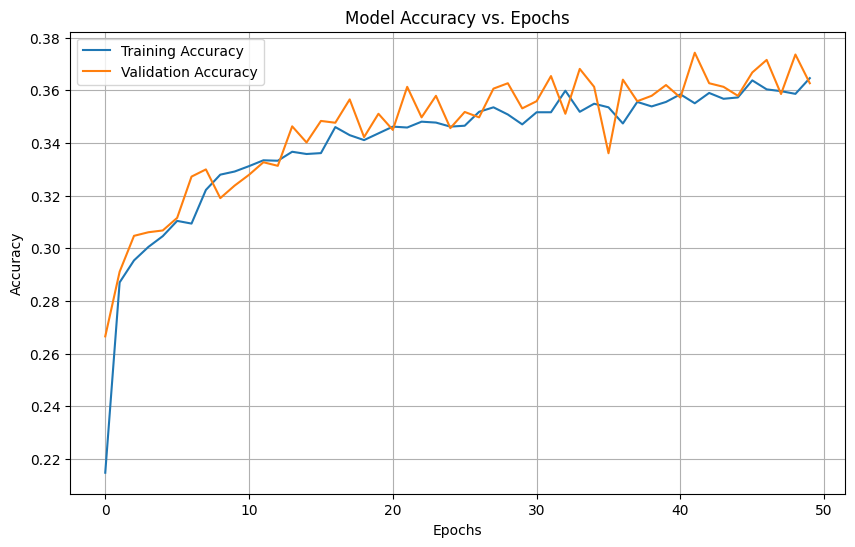

In [10]:
# Plot Training and Validation Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

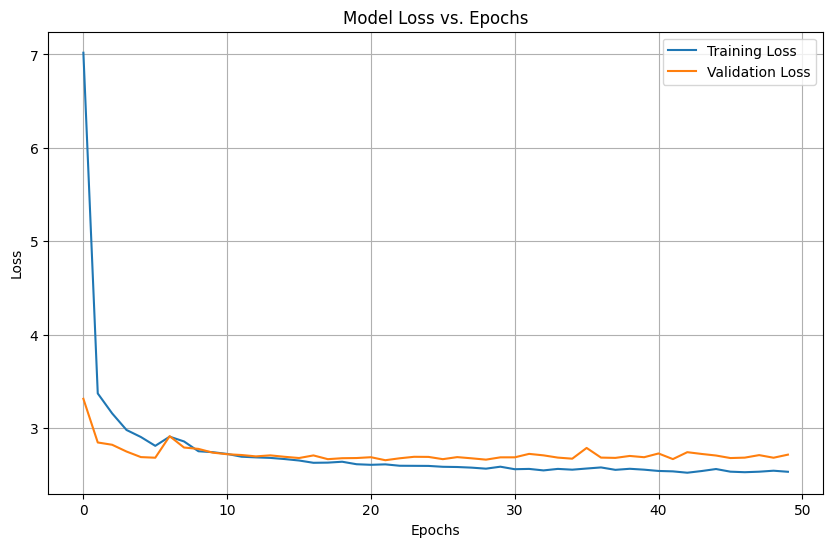

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()